# Task-1 Regression

Task1-Regression: Prediction of Property Resale Prices – given the information about a property (e.g., size, #rooms, location), your task is to predict its price based. This regression task is implemented as a Kaggle InClass Competition.

## Setting Up the NoteBook

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances

plt.style.use('fivethirtyeight')
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [103]:
data = pd.read_csv('./data/train.csv')

## Data Cleaning And EDA Process

In [104]:
print('Before cleaning, there are {} records.'.format(data.shape[0]))
data.isnull().sum()

Before cleaning, there are 20254 records.


listing_id                  0
title                       0
address                     0
property_name               0
property_type               0
tenure                   1723
built_year                922
num_beds                   80
num_baths                 434
size_sqft                   0
floor_level             16746
furnishing                  0
available_unit_types     1441
total_num_units          5652
property_details_url        0
lat                         0
lng                         0
elevation                   0
subzone                   113
planning_area             113
price                       0
dtype: int64

### Drop Some Field

In [105]:
data = data.drop(['elevation', 'floor_level', 'listing_id', 'address', 'property_name', 'title', 'property_details_url',
                  'total_num_units'], axis=1)

### Fill nan value

In [106]:
# fill na by mean
data[['built_year', 'num_beds', 'num_baths']] = data[['built_year', 'num_beds', 'num_baths']].fillna(
    data[['built_year', 'num_beds', 'num_baths']].mean())
# fill na by mode
data['available_unit_types'] = data['available_unit_types'].fillna(data['available_unit_types'].mode()[0])
data['tenure'] = data['tenure'].fillna(data['tenure'].mode()[0])

In [107]:
top10Dist = euclidean_distances(data[['lat', 'lng']], data[['lat', 'lng']]).argsort(axis=1)[:, :200]

In [108]:
for index, row in data[data['planning_area'].isna()].iterrows():
    paMode = data.loc[top10Dist[index]][~data['planning_area'].isna()]['planning_area'].mode()[0]
    szMode = data.loc[top10Dist[index]][~data['subzone'].isna()]['subzone'].mode()[0]
    data.at[index, 'planning_area'] = paMode
    data.at[index, 'subzone'] = szMode

In [109]:
data.astype({'subzone':str, 'planning_area':str})
data['subzone']

0           yishun south
1        serangoon north
2            mountbatten
3           farrer court
4                  anson
              ...       
20249             tagore
20250           lavender
20251           moulmein
20252     woodlands east
20253           moulmein
Name: subzone, Length: 20254, dtype: object

### Filter out outliers

In [110]:
# filter out outliers
data = data[(data['size_sqft'] <= data['size_sqft'].quantile(0.99)) & (data['size_sqft'] > 10)]
data.drop(data[data.price <= 0].index, inplace=True)

In [122]:
data["property_type"] = data["property_type"].str.lower()

In [123]:
print('After cleaning, there are now {} records.'.format(data.shape[0]))
data.isnull().sum()

After cleaning, there are now 19952 records.


property_type           0
tenure                  0
built_year              0
num_beds                0
num_baths               0
size_sqft               0
furnishing              0
available_unit_types    0
lat                     0
lng                     0
subzone                 0
planning_area           0
price                   0
dtype: int64

### Data visualization

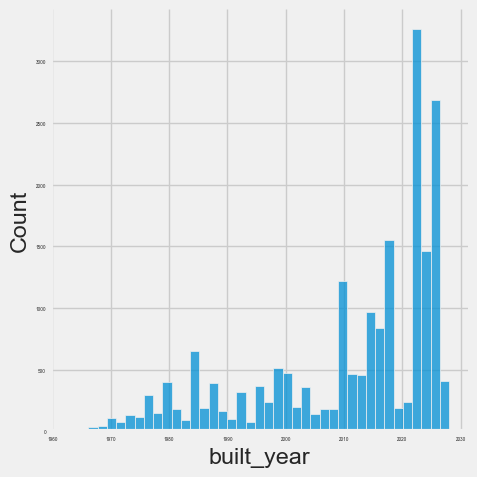

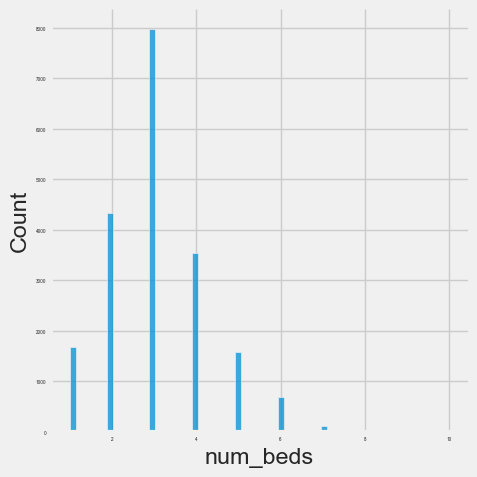

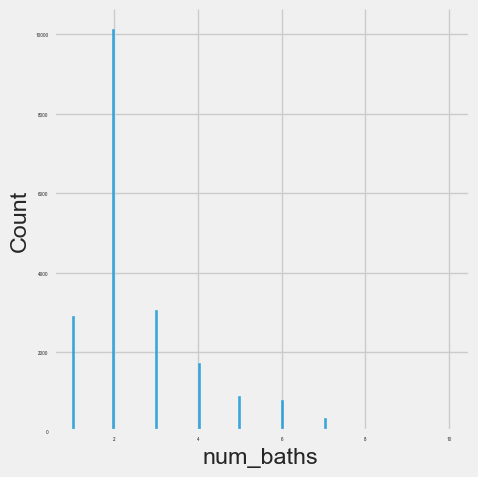

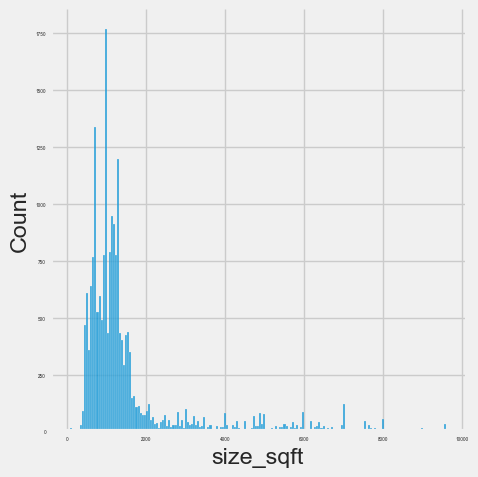

In [124]:
data['built_year'] = data['built_year'].astype(int)
data['num_baths'] = data['num_baths'].astype(int)
data['num_beds'] = data['num_beds'].astype(int)
sns.displot(data, x="built_year")
sns.displot(data, x="num_beds")
sns.displot(data, x="num_baths")
sns.displot(data, x="size_sqft")

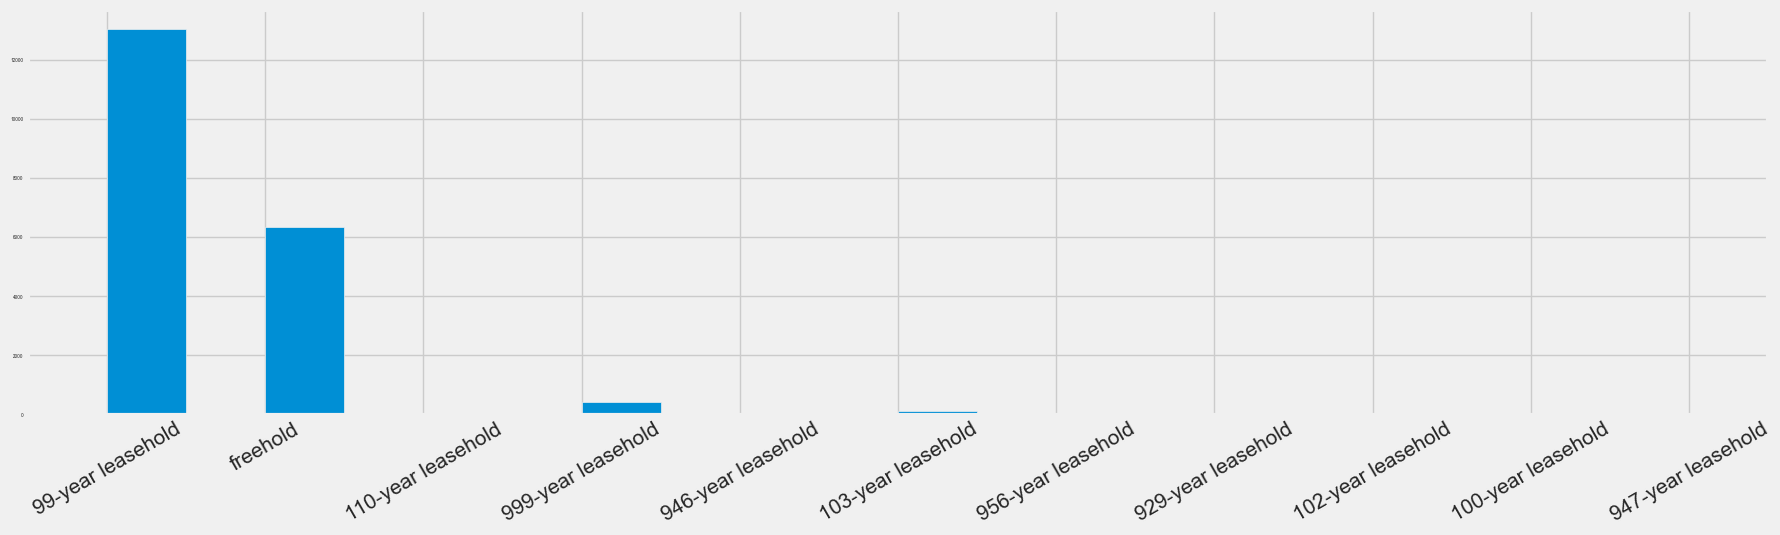

In [125]:
data = data.astype({'tenure': 'string'})
plt.figure(figsize=(20, 5), )
plt.tick_params(axis='x', labelsize=15)
plt.xticks(rotation=30)
plt.hist(data.tenure, bins=20)
plt.show()

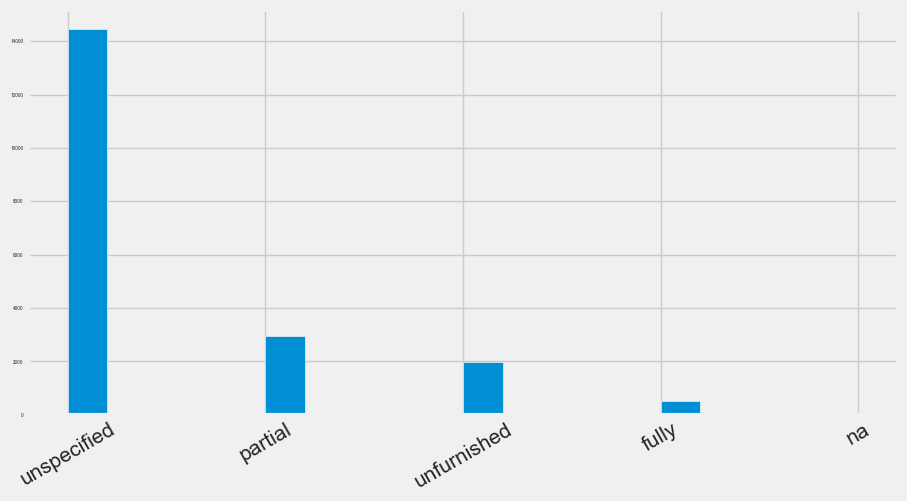

In [126]:
data = data.astype({'furnishing': 'string'})
plt.figure(figsize=(10, 5), )
plt.tick_params(axis='x', labelsize=15)
plt.xticks(rotation=30)
plt.hist(data.furnishing, bins=20)
plt.show()

In [127]:
print('After cleaning, there are now {} records each with {} attributes'.format(data.shape[0], data.shape[1]))
print(data.head())

After cleaning, there are now 19952 records each with 13 attributes
  property_type             tenure  built_year  num_beds  num_baths  \
0   hdb 4 rooms  99-year leasehold        1988         3          2   
1           hdb  99-year leasehold        1992         4          2   
2         condo           freehold        2022         4          6   
3         condo           freehold        2023         3          2   
4         condo  99-year leasehold        2026         2          1   

   size_sqft   furnishing      available_unit_types       lat         lng  \
0       1115  unspecified  studio, 1, 2, 3, 4, 5 br  1.414399  103.837196   
1       1575  unspecified       1, 2, 3, 4, 5, 6 br  1.372597  103.875625   
2       3070      partial     studio, 3, 4, 5, 6 br  1.298773  103.895798   
3        958      partial     studio, 1, 2, 3, 4 br  1.312364  103.803271   
4        732  unspecified  studio, 1, 2, 3, 4, 5 br  1.273959  103.843635   

           subzone  planning_area      pri

### Join with Auxiliary Data

In [128]:
from sklearn.metrics.pairwise import euclidean_distances

commercials = pd.read_csv('./data/auxiliary-data/sg-commerical-centres.csv')
mrts = pd.read_csv('./data/auxiliary-data/sg-mrt-stations.csv')
primary_schools = pd.read_csv('./data/auxiliary-data/sg-primary-schools.csv')
second_schools = pd.read_csv('./data/auxiliary-data/sg-secondary-schools.csv')
shoppings = pd.read_csv('./data/auxiliary-data/sg-shopping-malls.csv')
subzones = pd.read_csv('./data/auxiliary-data/sg-subzones.csv')

In [129]:
subzones[subzones['planning_area'] == 'toa payoh'].mean()

area_size         0.681700
population    10999.416667
dtype: float64

#### normalize lat/lng

In [130]:
normalizer = preprocessing.MinMaxScaler()
def normLatLng(X):
    X.lat = normalizer.fit_transform(X.lat.values.reshape(-1, 1))
    X.lng = normalizer.fit_transform(X.lng.values.reshape(-1, 1))
normLatLng(commercials)
normLatLng(mrts)
normLatLng(primary_schools)
normLatLng(second_schools)
normLatLng(shoppings)

### Feature Expand
Joining with auxiliary data, we compute the min distance from the properties to the shopping malls, mrts, commercial centers, etc.

In [131]:
data['shop_dist'] = euclidean_distances(data[['lat', 'lng']], shoppings[['lat', 'lng']]).min(axis=1)
data['mrt_dist'] = euclidean_distances(data[['lat', 'lng']], mrts[['lat', 'lng']]).min(axis=1)
data['commercials_dist'] = euclidean_distances(data[['lat', 'lng']], commercials[['lat', 'lng']]).min(axis=1)
data['second_school_dist'] = euclidean_distances(data[['lat', 'lng']], second_schools[['lat', 'lng']]).min(axis=1)
data['primary_school_dist'] = euclidean_distances(data[['lat', 'lng']], primary_schools[['lat', 'lng']]).min(axis=1)

# subzone: compute population density within the subzone
subzones = subzones[subzones.population > 0]
subzones['density'] = subzones.population / subzones.area_size
subzones.rename(columns={'name': 'subzone'}, inplace=True)
data = data.merge(subzones[['subzone', 'density']], how='left', on='subzone')

In [132]:
data.isnull().sum()

property_type           0
tenure                  0
built_year              0
num_beds                0
num_baths               0
size_sqft               0
furnishing              0
available_unit_types    0
lat                     0
lng                     0
subzone                 0
planning_area           0
price                   0
shop_dist               0
mrt_dist                0
commercials_dist        0
second_school_dist      0
primary_school_dist     0
density                 0
dtype: int64

[Text(0, 0.5, 'built_year'),
 Text(0, 1.5, 'num_beds'),
 Text(0, 2.5, 'num_baths'),
 Text(0, 3.5, 'size_sqft'),
 Text(0, 4.5, 'lat'),
 Text(0, 5.5, 'lng'),
 Text(0, 6.5, 'price'),
 Text(0, 7.5, 'shop_dist'),
 Text(0, 8.5, 'mrt_dist'),
 Text(0, 9.5, 'commercials_dist'),
 Text(0, 10.5, 'second_school_dist'),
 Text(0, 11.5, 'primary_school_dist'),
 Text(0, 12.5, 'density')]

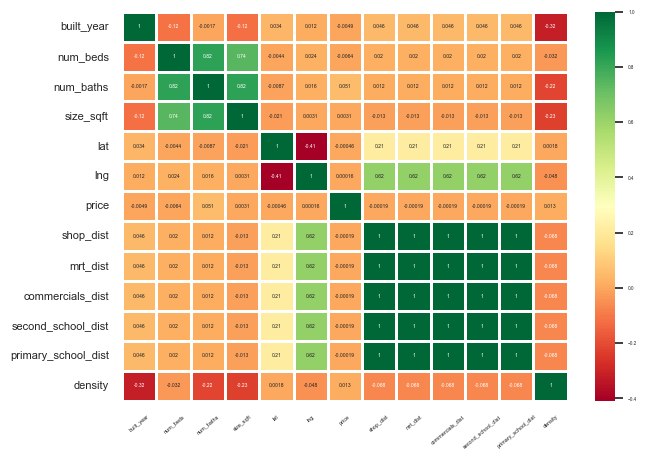

In [134]:
sns.set(font_scale=0.3)
heatmap = sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=1)  #data.corr()-->correlation matrix
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=40, fontsize=4)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=8)

In [137]:
data.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,lat,lng,subzone,planning_area,price,shop_dist,mrt_dist,commercials_dist,second_school_dist,primary_school_dist,density
0,hdb 4 rooms,99-year leasehold,1988,3,2,1115,unspecified,"studio, 1, 2, 3, 4, 5 br",1.414399,103.837196,yishun south,yishun,514500.0,102.841071,102.841248,102.841101,102.841689,102.840962,31517.683928
1,hdb,99-year leasehold,1992,4,2,1575,unspecified,"1, 2, 3, 4, 5, 6 br",1.372597,103.875625,serangoon north,serangoon,995400.0,102.879145,102.879313,102.879172,102.879734,102.879040,23280.268731
2,condo,freehold,2022,4,6,3070,partial,"studio, 3, 4, 5, 6 br",1.298773,103.895798,mountbatten,marine parade,8485000.0,102.898733,102.898887,102.898759,102.899273,102.898638,5829.779777
3,condo,freehold,2023,3,2,958,partial,"studio, 1, 2, 3, 4 br",1.312364,103.803271,farrer court,bukit timah,2626000.0,102.806312,102.806469,102.806338,102.806862,102.806215,11059.413028
4,condo,99-year leasehold,2026,2,1,732,unspecified,"studio, 1, 2, 3, 4, 5 br",1.273959,103.843635,anson,downtown core,1764000.0,102.846388,102.846537,102.846412,102.846911,102.846295,775.193798


### save to cleaned training

In [138]:
data.to_csv('./clean/train.csv', index=False)